# S&P 500 Model Building Using LSTM

### Import Libraries

In [15]:
import numpy as np
import pandas as pd 
import yfinance as yf
import matplotlib.pyplot as plt
from pandas_datareader import data
from datetime import date
from datetime import datetime
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

### Import Dataset

In [22]:
# import realtime dataset from yahoo finance to predict future stock price

from datetime import datetime

start = '2017-01-01'
end = datetime.now().strftime('%Y-%m-%d')
yf.pdr_override()
df = data.get_data_yahoo('^GSPC', start=start,end = end)
df.reset_index(inplace=True)

df.tail(5)

/opt/conda/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
1790,2024-02-14,4976.439941,5002.520020,4956.450195,5000.620117,5000.620117,3845600000
1791,2024-02-15,5003.140137,5032.720215,4999.439941,5029.729980,5029.729980,4137970000
1792,2024-02-16,5031.129883,5038.700195,4999.520020,5005.569824,5005.569824,3833270000
1793,2024-02-20,4989.319824,4993.709961,4955.020020,4975.509766,4975.509766,4034880000
1794,2024-02-21,4963.029785,4983.209961,4946.000000,4981.799805,4981.799805,3788390000


* **Plot Candlestick Graph**

In [23]:
fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                open=df['Open'], high=df['High'],
                low=df['Low'], close=df['Close'])])

fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

In [24]:
#df= df.drop(['Date', 'Adj Close'], axis= 1)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-03,2251.570068,2263.879883,2245.129883,2257.830078,2257.830078,3773010000
1,2017-01-04,2261.600098,2272.820068,2261.600098,2270.750000,2270.750000,3768890000
2,2017-01-05,2268.179932,2271.500000,2260.449951,2269.000000,2269.000000,3785080000
3,2017-01-06,2271.139893,2282.100098,2264.060059,2276.979980,2276.979980,3342080000
4,2017-01-09,2273.590088,2275.489990,2268.899902,2268.899902,2268.899902,3219730000


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1795 non-null   datetime64[ns]
 1   Open       1795 non-null   float64       
 2   High       1795 non-null   float64       
 3   Low        1795 non-null   float64       
 4   Close      1795 non-null   float64       
 5   Adj Close  1795 non-null   float64       
 6   Volume     1795 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 98.3 KB


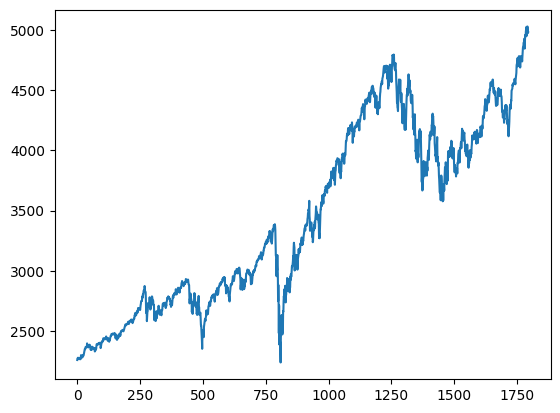

In [28]:
plt.plot(df["Close"])
plt.show()

In [29]:
# create moving average
# first 100 values are null then mean 
ma100 = df.Close.rolling(100).mean()
ma100

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
           ...     
1790    4577.338413
1791    4584.435112
1792    4591.116411
1793    4598.136211
1794    4605.209111
Name: Close, Length: 1795, dtype: float64

In [30]:
ma200 = df.Close.rolling(200).mean()
ma200

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
           ...     
1790    4476.359254
1791    4480.668553
1792    4485.098502
1793    4489.522301
1794    4494.125200
Name: Close, Length: 1795, dtype: float64

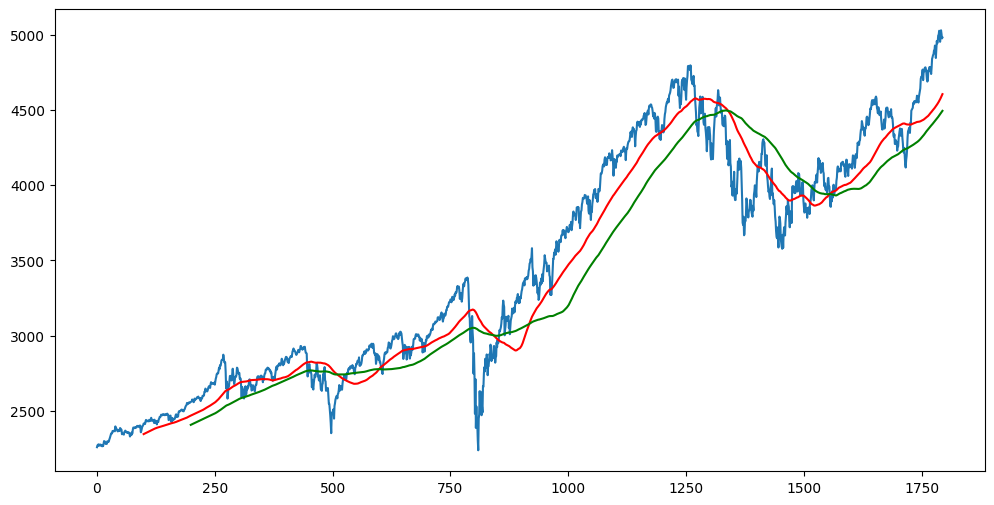

In [31]:
# plot moving average
plt.figure(figsize=(12,6))
plt.plot(df['Close'])
plt.plot(ma100, 'r')
plt.plot(ma200, 'g')
plt.show()

In [32]:
# splitting date into training and testing 
data_training= pd.DataFrame(df['Close'][0:int(len(df)*0.70)])
data_testing = pd.DataFrame(df['Close'][int(len(df)*0.70): int(len(df))])

print("training data: ",data_training.shape)
print("testing data: ", data_testing.shape)

training data:  (1256, 1)
testing data:  (539, 1)


In [33]:
data_training.head()

,Close
0,2257.830078
1,2270.750000
2,2269.000000
3,2276.979980
4,2268.899902


In [34]:
data_testing.head()

,Close
1256,4793.060059
1257,4778.729980
1258,4766.180176
1259,4796.560059
1260,4793.540039


In [35]:
# scaling of data using min max scaler (0,1)

scaler = MinMaxScaler(feature_range=(0,1))


In [36]:
data_training_array = scaler.fit_transform(data_training)
data_training_array

array([[0.00799994],
       [0.01305906],
       [0.0123738 ],
       ...,
       [0.97439104],
       [1.        ],
       [0.99810484]])

In [37]:
data_training_array.shape

(1256, 1)

In [38]:
x_train = []
y_train = []

for i in range(100, data_training_array.shape[0]):
    x_train.append(data_training_array[i-100:i])
    y_train.append(data_training_array[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

### ML Model

In [39]:
model = Sequential()
model.add(LSTM(units= 50, activation= 'relu', return_sequences= True, 
               input_shape= (x_train.shape[1], 1)))

model.add(Dropout(0.2))


model.add(LSTM(units= 60, activation= 'relu', return_sequences= True))

model.add(Dropout(0.3))


model.add(LSTM(units= 80, activation= 'relu', return_sequences= True))

model.add(Dropout(0.4))


model.add(LSTM(units= 120, activation= 'relu'))

model.add(Dropout(0.5))


model.add(Dense(units= 1))


In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_2 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [41]:
model.compile(optimizer='adam', loss="mean_squared_error")
model.fit(x_train, y_train, epochs= 25)

Epoch 1/25
37/37 [==============================] - 13s 223ms/step - loss: 0.0470
Epoch 2/25
37/37 [==============================] - 7s 189ms/step - loss: 0.0127
Epoch 3/25
37/37 [==============================] - 7s 188ms/step - loss: 0.0090
Epoch 4/25
37/37 [==============================] - 7s 186ms/step - loss: 0.0084
Epoch 5/25
37/37 [==============================] - 7s 192ms/step - loss: 0.0069
Epoch 6/25
37/37 [==============================] - 7s 190ms/step - loss: 0.0071
Epoch 7/25
37/37 [==============================] - 7s 185ms/step - loss: 0.0074
Epoch 8/25
37/37 [==============================] - 7s 186ms/step - loss: 0.0067
Epoch 9/25
37/37 [==============================] - 7s 186ms/step - loss: 0.0062
Epoch 10/25
37/37 [==============================] - 7s 193ms/step - loss: 0.0075
Epoch 11/25
37/37 [==============================] - 7s 185ms/step - loss: 0.0058
Epoch 12/25
37/37 [==============================] - 7s 186ms/step - loss: 0.0069
Epoch 13/25
37/37 [=====

In [43]:
# save model

# legacy method
model.save('stock_model.h5')

#moder method
model.save('stock_model.keras')

###  Model building is Successful !